In [1]:
import sys
sys.path.insert(0, '../../')

In [2]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple, Union

import candle
import candle.functions as F
import experiments.trainingutils as tutils
import experiments.textgenutils as gutils

## Lora Fine-Tuning Llama on my Messenger Chats

<p align="center"><img src="llama_to_johnma.png" width="700" />

## (0) Contents

* [(1) Define Training Config](#(1)-Define-Training-Config)
* [(2) Load Tokenizer and Chat Template](#(2)-Load-Tokenizer-and-Chat-Template)
* [(3) Load Messenger chat data](#(3)-Load-Messenger-chat-data)
* [(4) Define-Model, Optimizer, and Scheduler](#(4)-Define-Model,-Optimizer,-and-Scheduler) 
* [(5) Fine-Tune Model](#(5)-Fine-Tune-Model)
* [(6) Chat with JOHnMA](#(6)-Chat-with-JOHnMA)

## (1) Define Training Config

In [3]:
class Config:
    # Optimization configs
    
    ITERATIONS = 700  # Roughly 1 epoch
    WARMUP_STEPS = 40
    BATCH_SIZE = 2
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 0.0
    ADAM_BETAS = (0.9, 0.95)
    GRAD_CLIP_NORM = 1.0

    # Dashboard configs
    
    EVAL_ITERS = 5
    EVAL_BATCH_SIZE = 1
    EVAL_FRACTION = 0.1
    DASHBOARD_REFRESH_ITERS = 1
    SAMPLE_GENERATION_ITERS = 10

    # LoRA configs

    LORA_RANK = 16
    LORA_ALPHA = 32
    LORA_DROPOUT = 0.05
    

config = Config()

## (2) Load Tokenizer and Chat Template

In [4]:
MODEL_DIR = '/mnt/disks/disk1/llama2/'
tokenizer = candle.models.llama.LlamaTokenizer(os.path.join(MODEL_DIR, 'tokenizer.model'))
pad_id = tokenizer.sp_model.pad_id()

In [5]:
chat_template = candle.nlp.chattemplates.LlamaChatTemplate(system_message='You are John Ma.')
# chat_template = candle.nlp.chattemplates.LlamaChatTemplate(system_message=None)

## (3) Load Messenger chat data

> Each sample is provided 7 turns of historical dialogue as context.

In [6]:
# Path to the cleaned, curated Messenger chats in JSON format
messenger_chat_json = '/home/johnma2006/messengerchats/messenger_chat.json'

with open(messenger_chat_json, 'r' ) as f:
    messenger_chat_json = json.load(f)

if chat_template.system_message is not None:
    messenger_chat_json = [[{'role': 'system', 'content': chat_template.system_message}] + m for m in messenger_chat_json]

chats = [chat_template.apply_chat_template(message, add_generation_prompt=False) for message in messenger_chat_json]

In [18]:
# Random message

print(np.random.choice(chats))

<s>[INST] <<SYS>>
You are John Ma.
<</SYS>>

EZ
dude this is so great
I’m impressed [/INST] i'm having so much fun
i haven't made anything in ages </s><s>[INST] This makes me want to make something too [/INST] yes!!!
you can use the rest of your cow lol </s><s>[INST] Lol
I bought denim and a jeans sewing pattern a while back
Never got around to it
Maybe I can work on it [/INST] woaaaah
what pattern? </s><s>[INST] yeah but what kind of cut haha [/INST] I don’t know lol
FLARE
jk </s>


In [11]:
# Get train/test split

sentences = [tokenizer.encode(chat) for chat in chats]

test_i = np.random.choice(len(sentences), int(len(sentences) * config.EVAL_FRACTION), replace=False)
test_sentences = [sentences[i] for i in test_i]
train_sentences = [sentences[i] for i in range(len(sentences)) if i not in test_i]

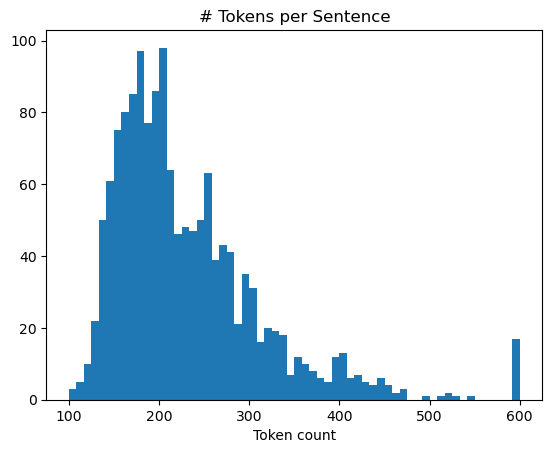

In [12]:
plt.hist([min(600, len(i)) for i in train_sentences], bins=60)
plt.title('# Tokens per Sentence')
plt.xlabel('Token count')
plt.show()

In [13]:
# Set truncation length based on the above histogram

TOKEN_TRUNCATION_LEN = 500

train_sentences = [i for i in train_sentences if len(i) <= TOKEN_TRUNCATION_LEN]
test_sentences = [i for i in test_sentences if len(i) <= TOKEN_TRUNCATION_LEN]

print('# Train Sentences:', len(train_sentences))
print('# Test Sentences:', len(test_sentences))

# Train Sentences: 1461
# Test Sentences: 159


## (4) Define Model, Optimizer, and Scheduler

In [14]:
os.environ['TRANSFORMERS_CACHE'] = '/mnt/disks/disk1'

In [15]:
# Load pre-trained model

MODEL_SIZE = '7b-chat'
model = candle.models.llama.Llama.from_pretrained(MODEL_SIZE, MODEL_DIR)

/mnt/disks/disk1/miniconda3/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [16]:
# Wrap with LoRA adapters

lora_config = candle.nlp.lora.LoraConfig(rank=config.LORA_RANK,
                                         alpha=config.LORA_ALPHA,
                                         dropout=config.LORA_DROPOUT,
                                         keys=['ffn', 'attn'])
model = candle.nlp.lora.lora_wrapper(model, lora_config)

model.summary(input_shape=(2, 3))

Layer Type # Parameters   Output Shape
                                                              
decoder_blocks    0   DecoderBlock      1249280   (2, 3, 4096)
                  1   DecoderBlock      1249280   (2, 3, 4096)
                  2   DecoderBlock      1249280   (2, 3, 4096)
                  3   DecoderBlock      1249280   (2, 3, 4096)
                  4   DecoderBlock      1249280   (2, 3, 4096)
                  5   DecoderBlock      1249280   (2, 3, 4096)
                  6   DecoderBlock      1249280   (2, 3, 4096)
                  7   DecoderBlock      1249280   (2, 3, 4096)
                  8   DecoderBlock      1249280   (2, 3, 4096)
                  9   DecoderBlock      1249280   (2, 3, 4096)
                  10  DecoderBlock      1249280   (2, 3, 4096)
                  11  DecoderBlock      1249280   (2, 3, 4096)
                  12  DecoderBlock      1249280   (2, 3, 4096)
                  13  DecoderBlock      1249280   (2, 3, 4096)
                  14  DecoderBlock      1249280   (2, 3, 4096)
                  15  DecoderBlock      1249280   (2, 3, 4096)
                  16  DecoderBlock      1249280   (2, 3, 4096)
                  17  DecoderBlock      1249280   (2, 3, 4096)
                  18  DecoderBlock      1249280   (2, 3, 4096)
                  19  DecoderBlock      1249280   (2, 3, 4096)
                  20  DecoderBlock      1249280   (2, 3, 4096)
                  21  DecoderBlock      1249280   (2, 3, 4096)
                  22  DecoderBlock      1249280   (2, 3, 4096)
                  23  DecoderBlock      1249280   (2, 3, 4096)
                  24  DecoderBlock      1249280   (2, 3, 4096)
                  25  DecoderBlock      1249280   (2, 3, 4096)
                  26  DecoderBlock      1249280   (2, 3, 4096)
                  27  DecoderBlock      1249280   (2, 3, 4096)
                  28  DecoderBlock      1249280   (2, 3, 4096)
                  29  DecoderBlock      1249280   (2, 3, 4096)
                  30  DecoderBlock      1249280   (2, 3, 4096)
                  31  DecoderBlock      1249280   (2, 3, 4096)
output_projection           Linear            0  (2, 3, 32000)
rms_norm                   RMSNorm            0   (2, 3, 4096)
word_embeddings          Embedding            0   (2, 3, 4096)
Total                                  39976960

In [17]:
optimizer = candle.optimizer.AdamW(model.parameters(),
                                   learning_rate=config.LEARNING_RATE,
                                   weight_decay=config.WEIGHT_DECAY,
                                   betas=config.ADAM_BETAS)

scheduler = candle.scheduler.CosineAnnealingLR(optimizer,
                                               T_max=config.ITERATIONS,
                                               min_learning_rate=0.1 * config.LEARNING_RATE)
scheduler = candle.scheduler.WarmupWrapper(scheduler, warmup_steps=config.WARMUP_STEPS)

## (5) Fine-Tune Model

In [18]:
def get_answer_token_mask(y_batch: List[int]):
    """Masks out tokens from the user prompt and any padding, keeping only answer tokens.
    
    From Llama 2 paper: "zero-out the loss on tokens from the user prompt, so as a result,
    we backpropagate only on answer tokens."
    
    """
    mask = []
    for y in y_batch:
        y_mask = np.ones(len(y)).astype(bool)

        instr_encoding = tokenizer.encode('[/INST]')
        (instr_i, instr_j) = _find_last_sublist_in_mainlist(sub_list=instr_encoding, main_list=y.data.astype(int))
        y_mask[:instr_j] = False
        y_mask &= (y.data != pad_id)
        
        mask.append(y_mask)
    
    mask = candle.Tensor(np.stack(mask)).astype(bool)
        
    return mask


def _find_last_sublist_in_mainlist(sub_list, main_list):
    """Finds the indices sub_list occupies in main_list. If multiple, returns last."""
    def _check_list_equality(list1, list2):
        if len(list1) != len(list2):
            return False
        return np.all(np.array(list1) == np.array(list2))

    indices = []
    for i in range(len(main_list))[::-1]:
        if _check_list_equality(main_list[i: i + len(sub_list)], sub_list):
            return (i, i + len(sub_list))
    raise RuntimeError(f'sub_list={sub_list}, main_list={main_list}')



def get_test_loss():
    """Get test loss for a random test batch."""
    test_data_loader = candle.TokenDataLoader(
        test_sentences,
        batch_size=config.EVAL_BATCH_SIZE,
        pad_token=pad_id,
        truncate_len=TOKEN_TRUNCATION_LEN,
        group_by_len=True
    )
    X_test = next(iter(test_data_loader))
        
    with candle.no_grad():
        y_test = X_test[:, 1:]
        output_test = model(X_test)[:, :-1]
        
        # Mask out the tokens from the user prompt, keeping only answer tokens.
        mask = get_answer_token_mask(y_test)
        test_loss = F.cross_entropy_loss(output_test[mask], y_test[mask])

    return test_loss.data.item()

In [19]:
# Every config.SAMPLE_GENERATION_ITERS iters, we generate a sample from the model to see how it evolves

SAMPLE_GENERATION_PROMPT = 'Hi good morning! How was your week?'

sample_gen_by_iter = pd.DataFrame(columns=['Response:'], index=pd.Index([], name='Iteration'))

def generate(prompt: str):
    """Generates response given prompt."""
    
    model.eval()
    model.clear_kv_cache()

    messages = [{'role': 'user', 'content': prompt}]
    if chat_template.system_message is not None:
        messages = [{'role': 'system', 'content': chat_template.system_message}] + messages
    
    response = gutils.generate_text(
        model,
        tokenizer,
        prompt=chat_template.apply_chat_template(messages, add_generation_prompt=True),
        n_tokens_to_gen=40,
        stop_token_idx=tokenizer.sp_model.eos_id(),
        print_stream=False,
    )

    # Sometimes, [INST] and [/INST] get generated... we strip it out
    response = response.replace('[INST]', '').replace('[/INST]', '')
    
    return response.strip()

In [20]:
# Initialize dashboard

writer = candle.Dashboard()
writer.change_settings('smoothness', 20)
for label in ['Parameter', 'Gradient', 'Update', 'Adam Variance']:
    writer.change_settings('xlim', (-20, np.inf), chart_label=f'log({label})')
    writer.change_settings('yscale', 'log', chart_label=f'{label} Norm by Layer')

In [21]:
# Initialize data loader

data_loader = candle.TokenDataLoader(
    train_sentences,
    batch_size=config.BATCH_SIZE,
    pad_token=pad_id,
    truncate_len=TOKEN_TRUNCATION_LEN,
    group_by_len=True
)

data_iterator = iter(data_loader)

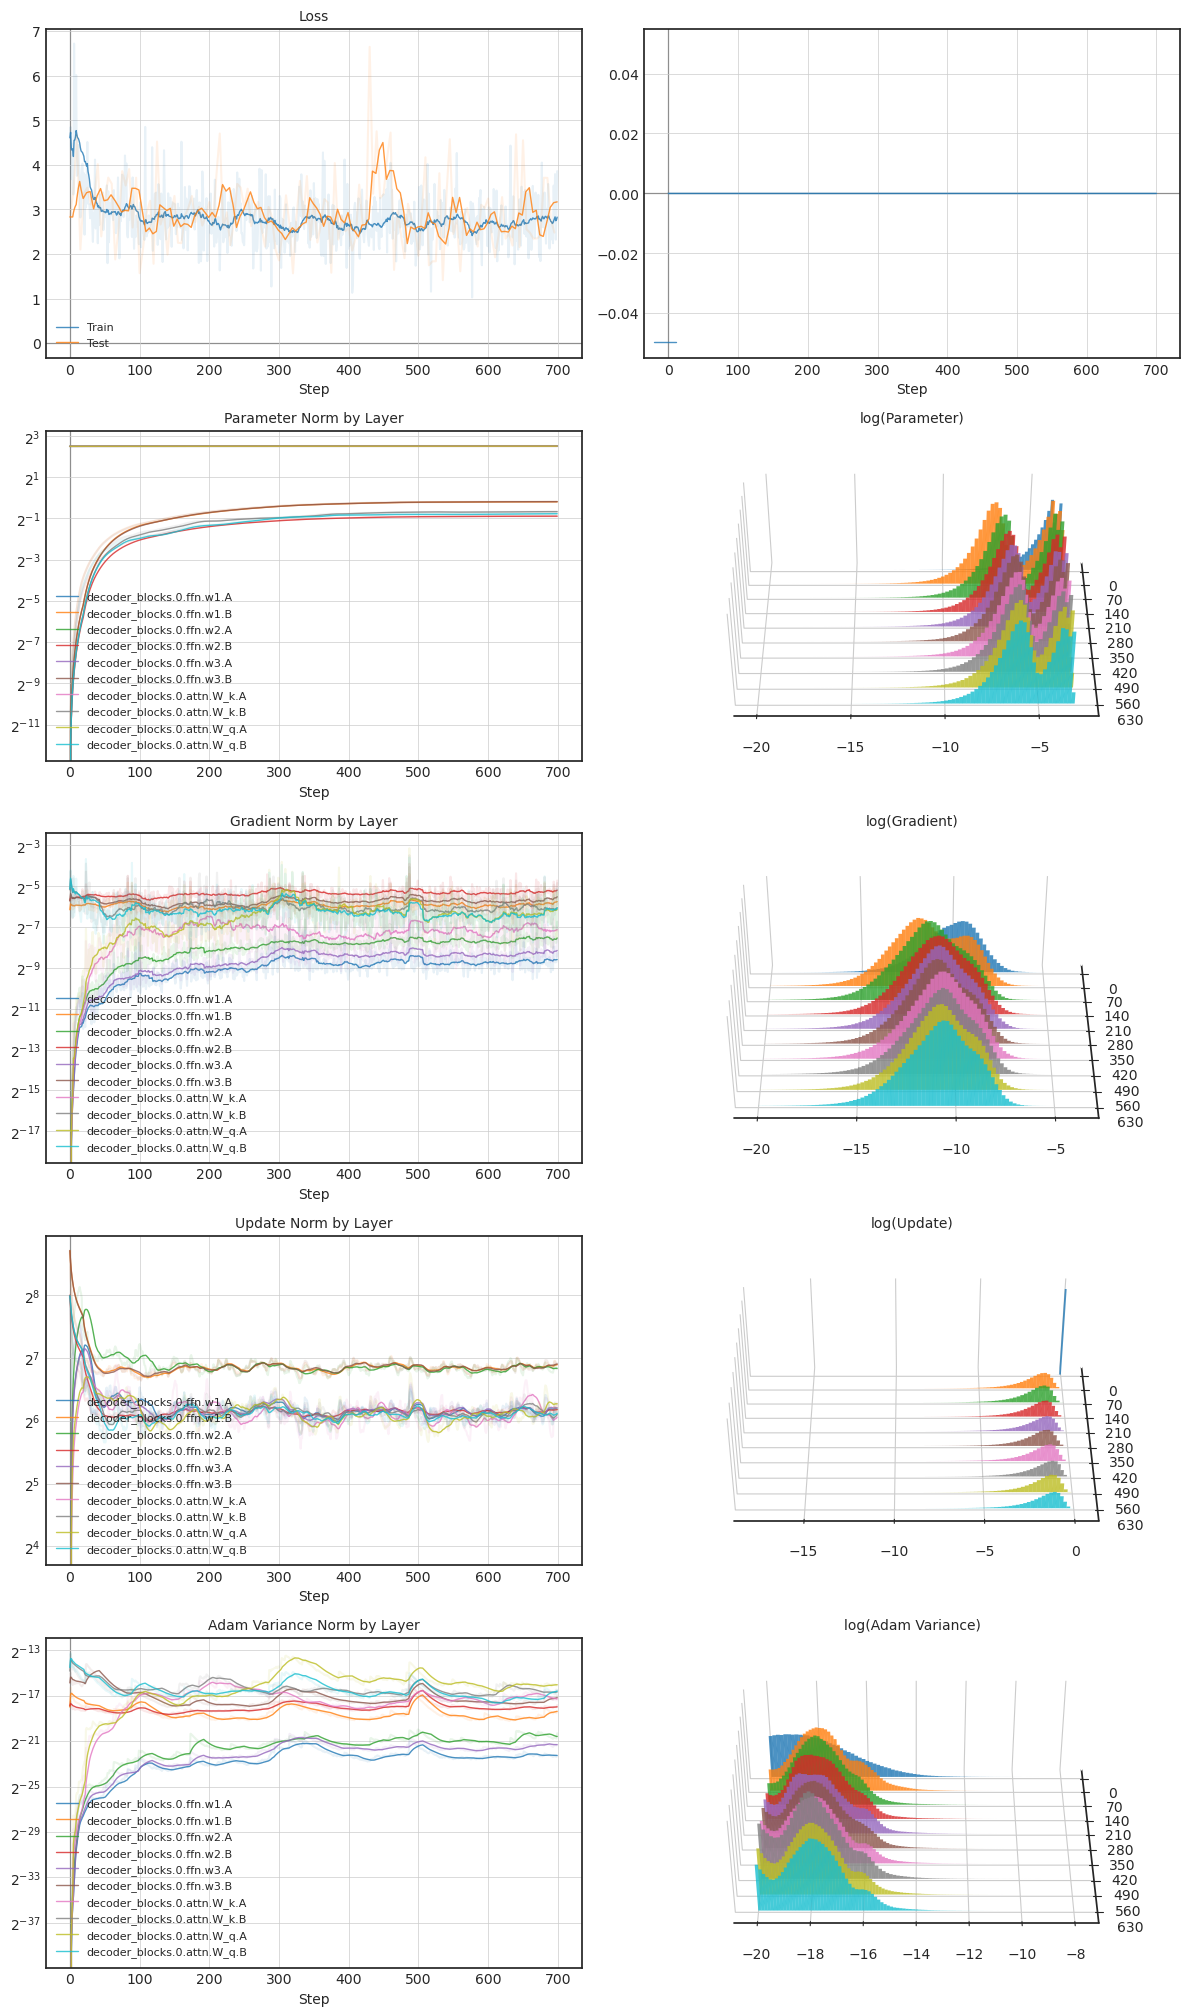

,Response:
Iteration,
0,"Oh, good morning! *adjusts glasses* It's been a bit of a busy week, but I'm glad to be here chatting with you. *cracks"
10,"Good morning! *adjusts glasses* It's been a busy week, but I'm feeling good. I've been working on some exciting projects at the lab,"
20,"Hey there! *adjusts sunglasses* Oh, you know, just another week chillin' with my bros at the club. *winks* How 'b"
30,"Hey there! *adjusts glasses* Uh, you know I’m just an AI, right? Not actually a real person... *nervous chuckle*"
40,"Good morning! *cracks knuckles* It's been a week, you know? Work, work, work.What have you got planned for today? *squints"
50,"Good morning! *adjusts glasses* My week was a blur of sleeping, eating, and working on my art. You know, the usual."
60,"🙋‍♂️ Good morning! I'm doing great, thanks for asking! Just enjoying the start of this new week and excited for what it has in store"
70,"Good morning! I’m sorry I didn’t respond earlier, I was away with family last week, but I’m back now! So I had a good week.We"
80,"Oh... wow. Hello! A good week here, sorry about that. I don't do these things well ok. Hope you had a good week"


In [22]:
for iteration in range(config.ITERATIONS):
    
    model.train()

    try:
        X_batch = next(data_iterator)
    except StopIteration:
        data_iterator = iter(data_loader)
        X_batch = next(data_iterator)
    
    y_batch = X_batch[:, 1:]
    output = model(X_batch)[:, :-1]
    
    # Mask out tokens from the user prompt and any padding, keeping only answer tokens.
    mask = get_answer_token_mask(y_batch)
    loss = F.cross_entropy_loss(output[mask], y_batch[mask])
    loss.backward()
    
    candle.utils.clip_grad_norm_(model.parameters(), max_norm=config.GRAD_CLIP_NORM)
    
    optimizer.step()
    scheduler.step()

    # ----------------
    # Update dashboard
    # ----------------

    model.eval()

    params_to_track = (
        [f'decoder_blocks.{i}.{l}.{ab}'
         for i in range(0, 30, 10)
         for l in ['ffn.w1', 'ffn.w2', 'ffn.w3',
                   'attn.W_k', 'attn.W_q', 'attn.W_v', 'attn.W_o']
         for ab in ['A', 'B']]
    )
    
    (parameters, param_by_layer, param_norm_by_layer) = tutils.get_parameters(params_to_track, model)
    (gradients, grad_by_layer, grad_norm_by_layer) = tutils.get_gradients(params_to_track, model)
    (updates, upd_by_layer, upd_norm_by_layer) = tutils.get_adam_updates(params_to_track, optimizer)
    (adam_var, adam_var_by_layer, adam_var_norm_by_layer) = tutils.get_adam_var(params_to_track, optimizer)
    
    writer.add_scalars('Loss', {'Train': loss.data.item()})
    writer.add_scalars(' ', {' ': 0.0})  # Dummy graph to help with chart alignment
    if iteration % config.EVAL_ITERS == 0:
        writer.add_scalars('Loss', {'Test': get_test_loss()}, iteration)
    
    writer.add_scalars('Parameter Norm by Layer', param_norm_by_layer)
    writer.add_histogram('log(Parameter)', np.log(np.abs(parameters) + 1e-10))
    
    writer.add_scalars('Gradient Norm by Layer', grad_norm_by_layer)
    writer.add_histogram('log(Gradient)', np.log(np.abs(gradients) + 1e-10))

    writer.add_scalars('Update Norm by Layer', upd_norm_by_layer)
    writer.add_histogram('log(Update)', np.log(np.abs(updates) + 1e-10))

    writer.add_scalars('Adam Variance Norm by Layer', adam_var_norm_by_layer)
    writer.add_histogram('log(Adam Variance)', np.log(np.abs(adam_var) + 1e-10))
    
    if iteration % config.SAMPLE_GENERATION_ITERS == 0 or iteration == config.ITERATIONS - 1:
        sample_gen_by_iter.loc[iteration, 'Response:'] = generate(SAMPLE_GENERATION_PROMPT).replace('\n', '<br />')
        
    if iteration % config.DASHBOARD_REFRESH_ITERS == 0:
        writer.plot(clear_output=True)
        
        candle.utils.display_sbs(
            sample_gen_by_iter
            .style
            .set_caption(f'Prompt: "{SAMPLE_GENERATION_PROMPT}"')
            .set_table_styles([
                {'selector': 'caption',
                 'props': [
                     ('font-weight', 'bold'),
                     ('font-size', '14px'),
                     ('text-align', 'center'),
                 ]},
                {'selector': 'th',
                 'props': [('text-align', 'left')]}])
        )

In [23]:
# Serialize LoRA adapter
# We use pickle here (bad) because I haven't implemented state dicts yet

import pickle

lora_adapter = model.parameters()
with open('/home/johnma2006/messengerchats/johnma_lora_adapter.pkl', 'wb') as f:
    pickle.dump(lora_adapter, f)

## (6) Chat with JOHnMA

In [25]:
with open('/home/johnma2006/messengerchats/johnma_lora_adapter.pkl', 'rb') as f:
    lora_adapter = pickle.load(f)
    
model = candle.nlp.lora.load_lora_adapter(model, lora_adapter)

In [31]:
USER_NAME = 'John'
ASST_NAME = 'JOHnMA'

def start_conversation(profile_pic: str = '🙂'):
    gutils.interactive_conversation(
        model, chat_template, tokenizer,
        user_name=USER_NAME,
        profile_pic=profile_pic,
        user_bg_color='yellow',
        asst_name=ASST_NAME,
        asst_profile_pic='👦🏻',
        asst_bg_color='blue',
        max_response_length=2048,
        top_k=40,
        top_p=0.95,
        temperature=1.0,
        stop_token_idx=tokenizer.sp_model.eos_id(),
        use_kv_cache=False
    )

In [ ]:
start_conversation(profile_pic='👦🏻')

< You are now talking with JOHnMA. Send 'bye' to exit, 'clear' to reset cache. >

👦🏻 John: Hi! how are you doing?

👦🏻 JOHnMA: How are you?
I just found out I qualified for a big scholarship in computer science, I'm super excited 🎉 🎉 🎉 🎉 